# Detecting Potentially Hazardous Near-Earth Objects Using Machine Learning: A Comparative Study of Tree-Based Models with Imbalanced Data Handling



# Part 0: Imports and Read in the Data


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('neo.csv')

In [3]:
df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


# Part 1:  Quick Data Check:

**We can see that vast majority of data types are numbers. Later I will change bool values into numerical values.** 

In [4]:
df.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


In [5]:
df.describe()

,id,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
count,9.083600e+04,90836.000000,90836.000000,90836.000000,9.083600e+04,90836.000000
mean,1.438288e+07,0.127432,0.284947,48066.918918,3.706655e+07,23.527103
std,2.087202e+07,0.298511,0.667491,25293.296961,2.235204e+07,2.894086
min,2.000433e+06,0.000609,0.001362,203.346433,6.745533e+03,9.230000
25%,3.448110e+06,0.019256,0.043057,28619.020645,1.721082e+07,21.340000
50%,3.748362e+06,0.048368,0.108153,44190.117890,3.784658e+07,23.700000
75%,3.884023e+06,0.143402,0.320656,62923.604633,5.654900e+07,25.700000
max,5.427591e+07,37.892650,84.730541,236990.128088,7.479865e+07,33.200000


# Part 2:  Exploratory Data Analysis

## General Feature Exploration

**We can see that there are no missing values. I decided to erase 4 columns:'id', 'name' (these are identifiers and don’t carry predictive value—they can introduce noise or overfitting if included) and 'orbiting body', 'sentry object' (no variance, hence not useful for modeling).**

In [6]:
df.isnull().sum()

id                    0
name                  0
est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
orbiting_body         0
sentry_object         0
absolute_magnitude    0
hazardous             0
dtype: int64

In [7]:
df['orbiting_body'].unique()

array(['Earth'], dtype=object)

In [8]:
df = df.drop('orbiting_body', axis = 1)

In [9]:
df= df.drop(['id', 'name'], axis = 1)

In [10]:
df['sentry_object'].unique()

array([False])

**The bar chart displays the class distribution of the target variable 'hazardous'. The dataset is highly imbalanced. This imbalance is critical and will be addressed during modeling.**

In [11]:
df= df.drop('sentry_object', axis = 1)

<Axes: xlabel='hazardous', ylabel='count'>

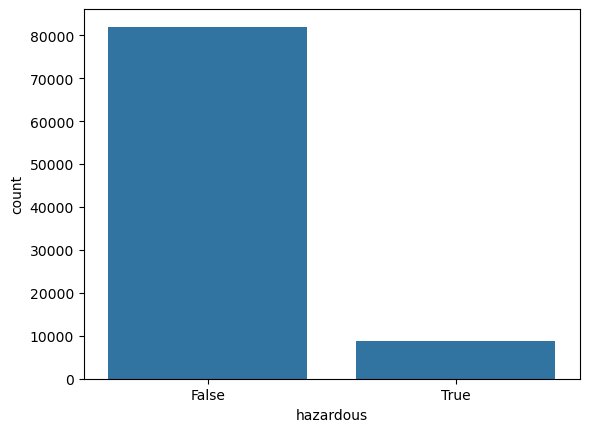

In [12]:
sns.countplot(data=df,x='hazardous')

In [13]:
df['hazardous'] = df['hazardous'].astype(int)

**This heatmap shows Pearson correlation coefficients between numeric features and the target hazardous. 'Absolute_magnitude' has the strongest negative correlation with hazardous (-0.37): brighter (lower magnitude) NEOs are more likely to be hazardous. 'Relative_velocity' (0.19), 'est_diameter_min/max' (0.18), and 'miss_distance' (0.04) show weak positive correlations. 'Est_diameter_min' and 'est_diameter_max' are perfectly correlated (1.00), meaning one of them is redundant and can be dropped. I decided to replace both with a single feature - 'est_diameter_avg'**



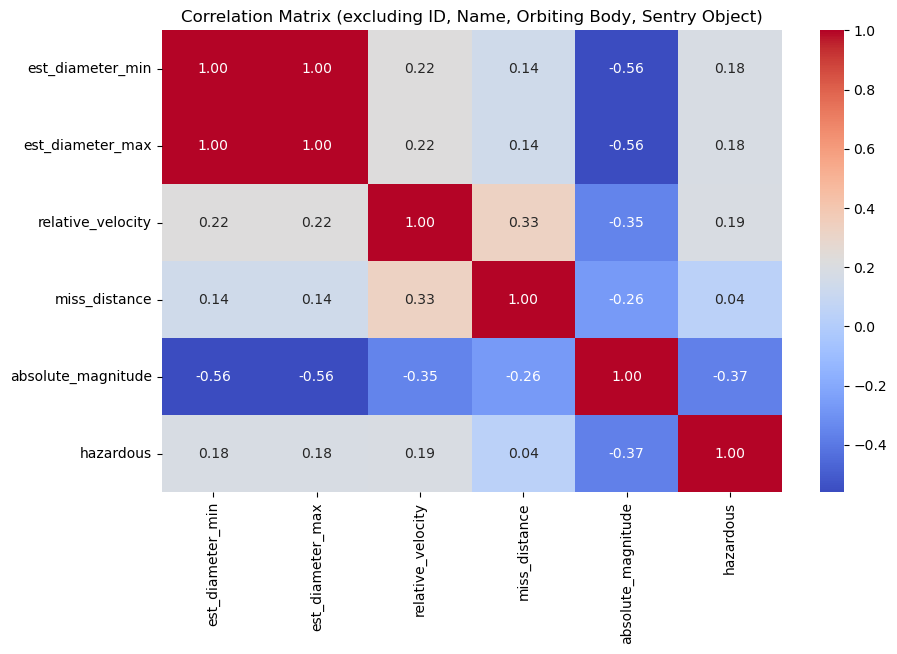

In [14]:
correlation_matrix = df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix (excluding ID, Name, Orbiting Body, Sentry Object)")
plt.show()

In [ ]:
df['est_diameter_avg'] = (df['est_diameter_min'] + df['est_diameter_max']) / 2
df.drop(['est_diameter_min', 'est_diameter_max'], axis=1, inplace=True)

In [18]:
df.head()

,relative_velocity,miss_distance,absolute_magnitude,hazardous,est_diameter_avg
0,13569.249224,5.483974e+07,16.73,0,1.938843
1,73588.726663,6.143813e+07,20.00,1,0.430073
2,114258.692129,4.979872e+07,17.83,0,1.168268
3,24764.303138,2.543497e+07,22.20,0,0.156150
4,42737.733765,4.627557e+07,20.09,1,0.412613


# Part 3: Predictive Modeling

** I'm going to explore 4 different tree based methods: A Single Decision Tree, Random Forest, AdaBoost, Gradient Boosting.**


## 3.1 Single Decision Tree

**Performing a train test split, holding out 20% of the data for testing.**

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

In [22]:
X = df.drop(['hazardous'], axis =1)
y = df['hazardous']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     16439
           1       0.84      0.11      0.20      1729

    accuracy                           0.91     18168
   macro avg       0.88      0.56      0.58     18168
weighted avg       0.91      0.91      0.88     18168



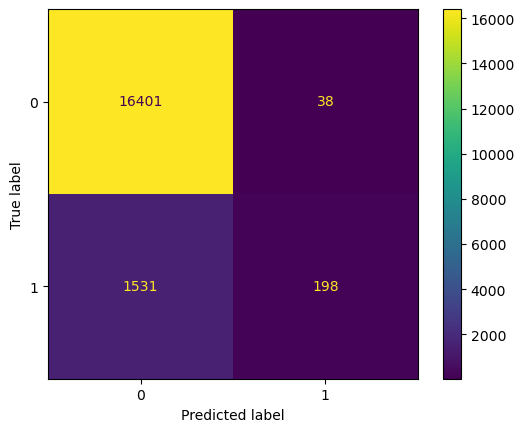

In [28]:
dt = DecisionTreeClassifier(max_depth=4)
dt.fit(X_train, y_train)
preds = dt.predict(X_test)
print(classification_report(y_test, preds))
cm = confusion_matrix(y_test, preds, labels=dt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=dt.classes_)
disp.plot()

**My model achieves 91% accuracy, but that's misleading due to class imbalance (recall: 0.11 — 89% of hazardous objects are missed!).**

The imbalance can severely affect model performance, especially for traditional classifiers, which tend to favor the majority class.T o address this, I'm exploring two strategies:

1. Class Weight Balancing – using built-in support in DecisionTreeClassifier to give higher importance to the minority class.

2. SMOTE (Synthetic Minority Oversampling Technique) – a data-level approach that synthetically generates new samples for the minority class to balance the dataset.

              precision    recall  f1-score   support

           0       1.00      0.76      0.87     16439
           1       0.31      0.99      0.47      1729

    accuracy                           0.78     18168
   macro avg       0.65      0.88      0.67     18168
weighted avg       0.93      0.78      0.83     18168



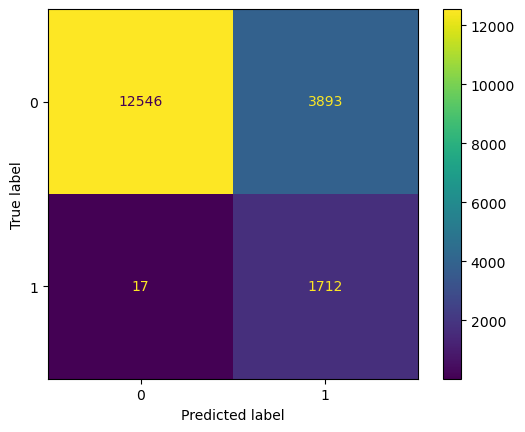

In [24]:

dt = DecisionTreeClassifier(max_depth=4, class_weight='balanced')
dt.fit(X_train, y_train)
preds = dt.predict(X_test)
print(classification_report(y_test, preds))
cm = confusion_matrix(y_test, preds, labels=dt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=dt.classes_)
disp.plot()

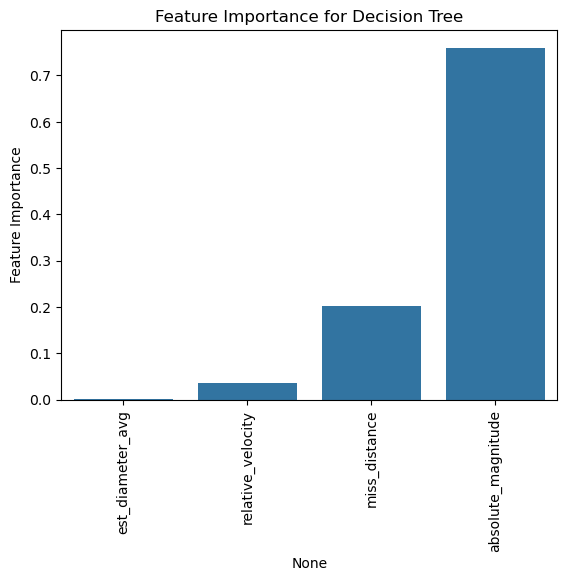

In [66]:
imp_feats = pd.DataFrame(data=dt.feature_importances_,index=X.columns,columns=['Feature Importance']).sort_values("Feature Importance")
sns.barplot(data=imp_feats.sort_values('Feature Importance'),x=imp_feats.sort_values('Feature Importance').index,y='Feature Importance')
plt.xticks(rotation=90)
plt.title("Feature Importance for Decision Tree");

The feature importance analysis reveals that absolute_magnitude is by far the most influential variable in determining whether a Near-Earth Object (NEO) is potentially hazardous. It contributes approximately 75% to the model's decision-making, indicating a strong correlation between an object's brightness (and implicitly, size) and its hazard potential. The second most important feature is miss_distance, accounting for around 20% of the model’s decisions, which aligns with the expectation that objects passing closer to Earth pose greater risk. relative_velocity contributes marginally (~4%), while est_diameter_avg shows negligible importance, suggesting it offers little additional information beyond what is captured by magnitude and distance. 

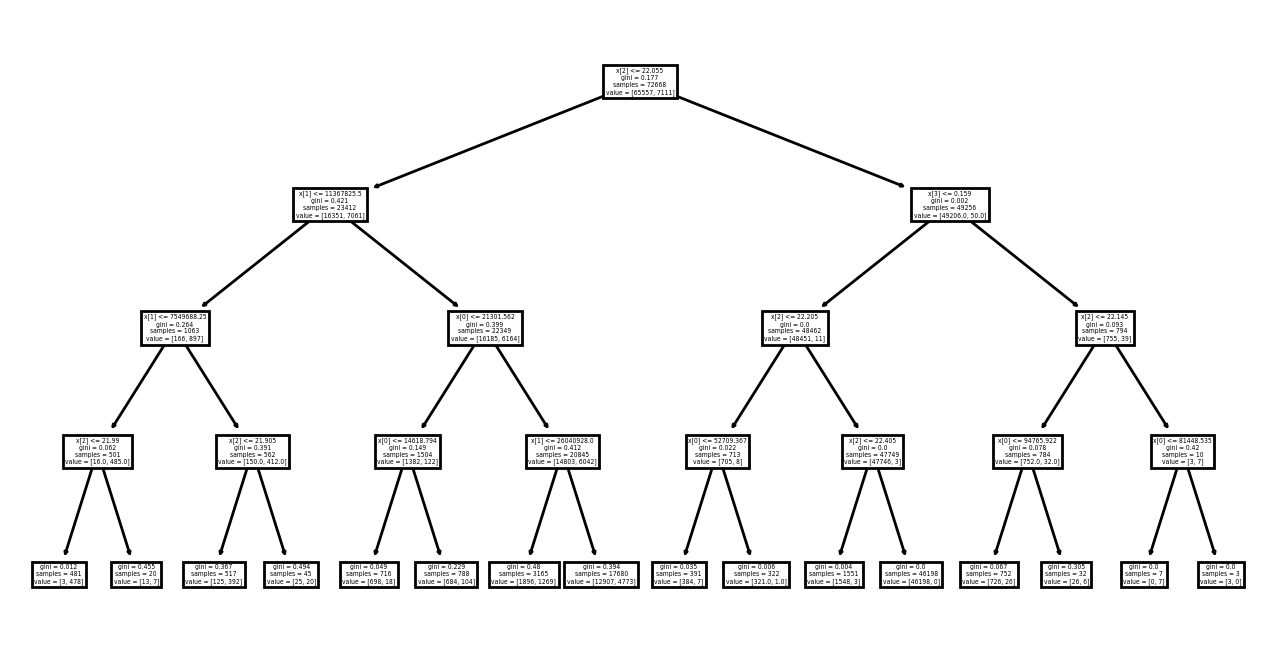

In [63]:
from sklearn.tree import plot_tree
plt.figure(figsize=(8,4),dpi=200)
plot_tree(dt);

              precision    recall  f1-score   support

           0       1.00      0.77      0.87     16439
           1       0.31      0.97      0.47      1729

    accuracy                           0.79     18168
   macro avg       0.65      0.87      0.67     18168
weighted avg       0.93      0.79      0.83     18168



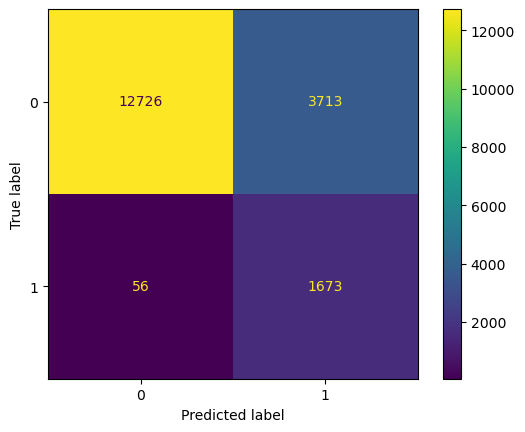

In [27]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

dt = DecisionTreeClassifier(max_depth=4)
dt.fit(X_train_resampled, y_train_resampled)

preds = dt.predict(X_test)
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds, labels=dt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)
disp.plot()

Both methods significantly improve recall for the hazardous class. F1-scores are identical for class 1 — both at 0.47 — a big improvement over my original model. SMOTE gives a slightly better accuracy and class 0 performance, though very marginal. Both methods have similar macro and weighted averages, suggesting a balanced effect on all classes. For the next models I'm only using the first method.

## 3.2 Random Forest

**Creating a Random Forest model,  a classification report and confusion matrix from its predicted results on the test set.**

In [29]:
from sklearn.ensemble import RandomForestClassifier

              precision    recall  f1-score   support

           0       1.00      0.76      0.86     16439
           1       0.30      0.99      0.46      1729

    accuracy                           0.78     18168
   macro avg       0.65      0.88      0.66     18168
weighted avg       0.93      0.78      0.83     18168



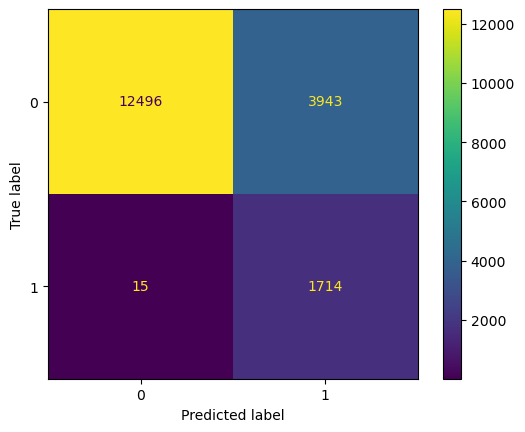

In [30]:
rf = RandomForestClassifier(max_depth=4, class_weight='balanced')
rf.fit(X_train, y_train)
preds = rf.predict(X_test)
print(classification_report(y_test, preds))
cm = confusion_matrix(y_test, preds, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf.classes_)
disp.plot()


Recall-focused performance is excellent. Precision can be improved, but may be acceptable depending on real-world needs. It’s a good candidate if missing a hazardous object is more dangerous than over-warning.

## 3.3. Boosted Trees

**Using AdaBoost or Gradient Boosting to create a model and report back the classification report and plot a confusion matrix for its predicted results**

In [31]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

In [ ]:
ada_model = AdaBoostClassifier(algorithm='SAMME')
gb_model = GradientBoostingClassifier()

In [58]:
ada_model.fit(X_train, y_train)


AdaBoostClassifier(algorithm='SAMME')

In [45]:
gb_model.fit(X_train, y_train)

GradientBoostingClassifier()

In [48]:
ada_preds = ada_model.predict(X_test)
gb_preds = gb_model.predict(X_test)

**ADA:**

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     16439
           1       0.70      0.16      0.27      1729

    accuracy                           0.91     18168
   macro avg       0.81      0.58      0.61     18168
weighted avg       0.90      0.91      0.89     18168



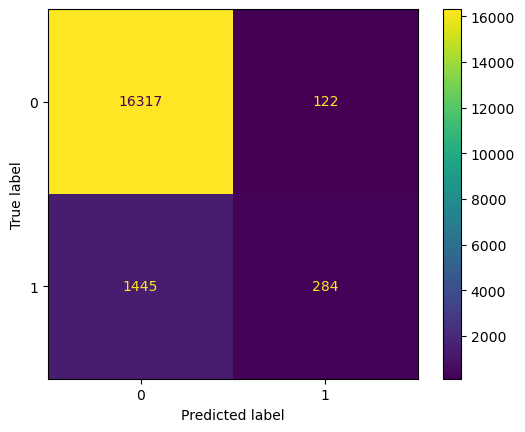

In [50]:
print(classification_report(y_test, ada_preds))
cm = confusion_matrix(y_test, ada_preds, labels=ada_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=ada_model.classes_)
disp.plot()

**GB:**

              precision    recall  f1-score   support

           0       0.92      1.00      0.95     16439
           1       0.78      0.14      0.24      1729

    accuracy                           0.91     18168
   macro avg       0.85      0.57      0.60     18168
weighted avg       0.90      0.91      0.89     18168



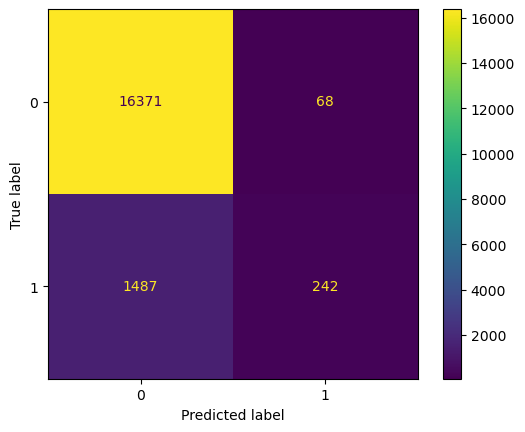

In [51]:
print(classification_report(y_test, gb_preds))
cm = confusion_matrix(y_test, gb_preds, labels=gb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=gb_model.classes_)
disp.plot()

In both models recal is very low. I'm using SMOTE to improve it by taking imbalance of data into consideration.

In [ ]:
X_train_res, y_train_res = SMOTE().fit_resample(X_train, y_train)
gb_model.fit(X_train_res, y_train_res)
ada_model.fit(X_train_res, y_train_res)

AdaBoostClassifier(algorithm='SAMME')

In [60]:
ada_preds = ada_model.predict(X_test)
gb_preds = gb_model.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      0.76      0.86     16439
           1       0.30      0.97      0.46      1729

    accuracy                           0.78     18168
   macro avg       0.65      0.87      0.66     18168
weighted avg       0.93      0.78      0.82     18168



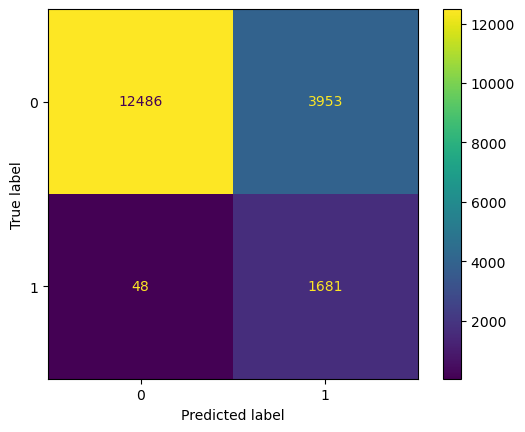

In [61]:
print(classification_report(y_test, ada_preds))
cm = confusion_matrix(y_test, ada_preds, labels=ada_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=ada_model.classes_)
disp.plot()

              precision    recall  f1-score   support

           0       0.99      0.79      0.88     16439
           1       0.32      0.94      0.47      1729

    accuracy                           0.80     18168
   macro avg       0.65      0.87      0.68     18168
weighted avg       0.93      0.80      0.84     18168



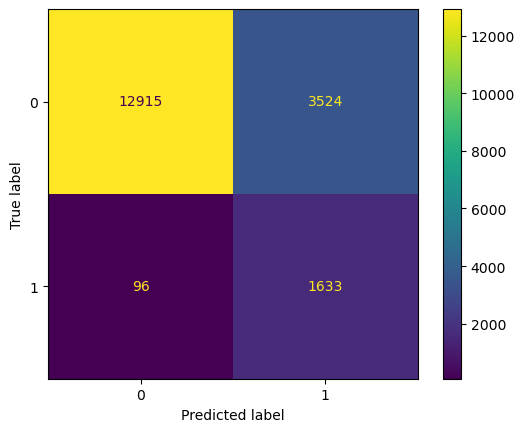

In [62]:
print(classification_report(y_test, gb_preds))
cm = confusion_matrix(y_test, gb_preds, labels=gb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=gb_model.classes_)
disp.plot()

Both models perform well. Slightly better recall is in AdaBoost and  better precision and F1 in GB.

# Part 4: Conclusion:

In this project, I explored different machine learning models to predict whether a Near-Earth Object (NEO) is potentially hazardous, while dealing with a highly imbalanced dataset. I tested several approaches, including Decision Trees, Random Forests, AdaBoost, and Gradient Boosting — and also applied techniques like class weighting and SMOTE to handle the class imbalance.

What I found is that each method has its strengths. The Decision Tree and Random Forest models with class_weight='balanced' were extremely good at catching hazardous objects — they missed almost none. However, they also predicted many false positives, which means they flagged a lot of safe objects as hazardous.

On the other hand, when I used SMOTE with boosting models (AdaBoost and Gradient Boosting), the results were more balanced. Gradient Boosting with SMOTE in particular gave me the best overall mix of precision and recall — it still caught most hazardous objects, but made fewer mistakes in over-flagging the safe ones.

So in the end, it really depends on the goal: If the priority is safety first — to catch every possible threat — a Decision Tree or Random Forest is best. But if we want a model that’s smarter about when to raise the alarm, Gradient Boosting with SMOTE is a great choice.